![forecasting_framework](../forecasting_framework.png)

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from pmdarima.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.stattools import adfuller, kpss

from math import sqrt

In [64]:
TRAIN_CSV_PATH = r"../datasets/train.csv"
PRICES_CSV_PATH = r"../datasets/prices.csv"
CAL_CSV_PATH = r"../datasets/calendar.csv"
SAMPLE_CSV_PATH = r"../datasets/sample_submission.csv"

EXPORT_PATH = r"../submissions/"

In [65]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [66]:
def plot_differencing(series, n = 8) :

    fig, axes = plt.subplots(n, 3, figsize = (20,25))

    axes[0, 0].plot(series); axes[0, 0].set_title('Original Series')
    plot_acf(series, ax=axes[0, 1])

    for i in range(1, n) :
        diff_series = series.diff(periods = i)

        axes[i, 0].plot(diff_series); axes[i, 0].set_title(f'{i}th Order Differencing')
        plot_acf(diff_series.dropna(), ax=axes[i, 1])
        plot_pacf(diff_series.dropna(), method='ywm', ax = axes[i, 2])


    plt.show()

In [67]:
df_train = pd.read_csv(TRAIN_CSV_PATH)
df_train.head()

,id,item_id,subcat_id,category_id,store_id,region_id,d_1,d_2,d_3,d_4,...,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919
0,Beauty_1_001_East_1,Beauty_1_001,Beauty_1,Beauty,East_1,East,0,0,0,0,...,3,0,1,1,0,0,0,2,0,3
1,Beauty_1_002_East_1,Beauty_1_002,Beauty_1,Beauty,East_1,East,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,Beauty_1_003_East_1,Beauty_1_003,Beauty_1,Beauty,East_1,East,0,0,0,0,...,0,1,1,1,0,0,1,1,0,2
3,Beauty_1_004_East_1,Beauty_1_004,Beauty_1,Beauty,East_1,East,0,0,0,0,...,1,3,7,2,0,0,1,2,4,1
4,Beauty_1_005_East_1,Beauty_1_005,Beauty_1,Beauty,East_1,East,0,0,0,0,...,2,2,2,4,1,0,2,3,1,0


In [68]:
# Convert to appropriate datatypes
df_train["id"] = df_train["id"].astype("string")
df_train["item_id"] = df_train["item_id"].astype("string")
df_train["subcat_id"] = df_train["subcat_id"].astype("string")
df_train["category_id"] = df_train["category_id"].astype("string")
df_train["store_id"] = df_train["store_id"].astype("string")
df_train["region_id"] = df_train["region_id"].astype("string")

In [69]:
df_cal = pd.read_csv(CAL_CSV_PATH)
df_cal.head()

,date,wm_yr_wk,weekday,wday,month,year,d
0,2011-01-29,11101,Saturday,1,1,2011,d_1
1,2011-01-30,11101,Sunday,2,1,2011,d_2
2,2011-01-31,11101,Monday,3,1,2011,d_3
3,2011-02-01,11101,Tuesday,4,2,2011,d_4
4,2011-02-02,11101,Wednesday,5,2,2011,d_5


In [70]:
# Change dtypes
df_cal["date"] = pd.to_datetime(df_cal["date"])
df_cal["weekday"] = df_cal["weekday"].astype("string")
df_cal["d"] = df_cal["d"].astype("string")
df_cal["wm_yr_wk"] = df_cal["wm_yr_wk"].astype(int)

# Add column with months in string
month_names_ls = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
month_int_ls = list(range(1, 13))
month_names_dict = {month_int_ls[i]: month_names_ls[i] for i in range(len(month_int_ls))}

df_cal["month_name"] = df_cal["month"].replace(month_names_dict)

In [71]:
# Save day IDs from train
day_ids = list(df_train.columns[6:])

df_items_temp = df_train[["id"]+day_ids].T
df_items_temp.columns = df_items_temp.iloc[0, :]

# Drop first row
df_items_temp = df_items_temp.iloc[1: , :]

# Copy the index to merge date
df_items_temp["d"] = df_items_temp.index

# Merge date into df
df_items_temp = pd.merge(df_items_temp, df_cal, on = "d", how = "left")
df_items_temp = df_items_temp.set_index("date")

# Calculate average items across items per day
df_items_temp["avg_items_sold"] = df_items_temp[list(df_train["id"])].mean(axis = 1)

In [72]:
df_items_temp.head()

,Beauty_1_001_East_1,Beauty_1_002_East_1,Beauty_1_003_East_1,Beauty_1_004_East_1,Beauty_1_005_East_1,Beauty_1_006_East_1,Beauty_1_007_East_1,Beauty_1_008_East_1,Beauty_1_009_East_1,Beauty_1_010_East_1,...,Food_3_826_West_3,Food_3_827_West_3,d,wm_yr_wk,weekday,wday,month,year,month_name,avg_items_sold
date,,,,,,,,,,,,,,,,,,,,,
2011-01-29,0,0,0,0,0,0,0,12,2,0,...,0,0,d_1,11101,Saturday,1,1,2011,Jan,1.070220
2011-01-30,0,0,0,0,0,0,0,15,0,0,...,0,0,d_2,11101,Sunday,2,1,2011,Jan,1.041292
2011-01-31,0,0,0,0,0,0,0,0,7,1,...,0,0,d_3,11101,Monday,3,1,2011,Jan,0.780026
2011-02-01,0,0,0,0,0,0,0,0,3,0,...,0,0,d_4,11101,Tuesday,4,2,2011,Feb,0.833454
2011-02-02,0,0,0,0,0,0,0,0,0,0,...,0,0,d_5,11101,Wednesday,5,2,2011,Feb,0.627944


#### Plot differencing for lag 1 - 7

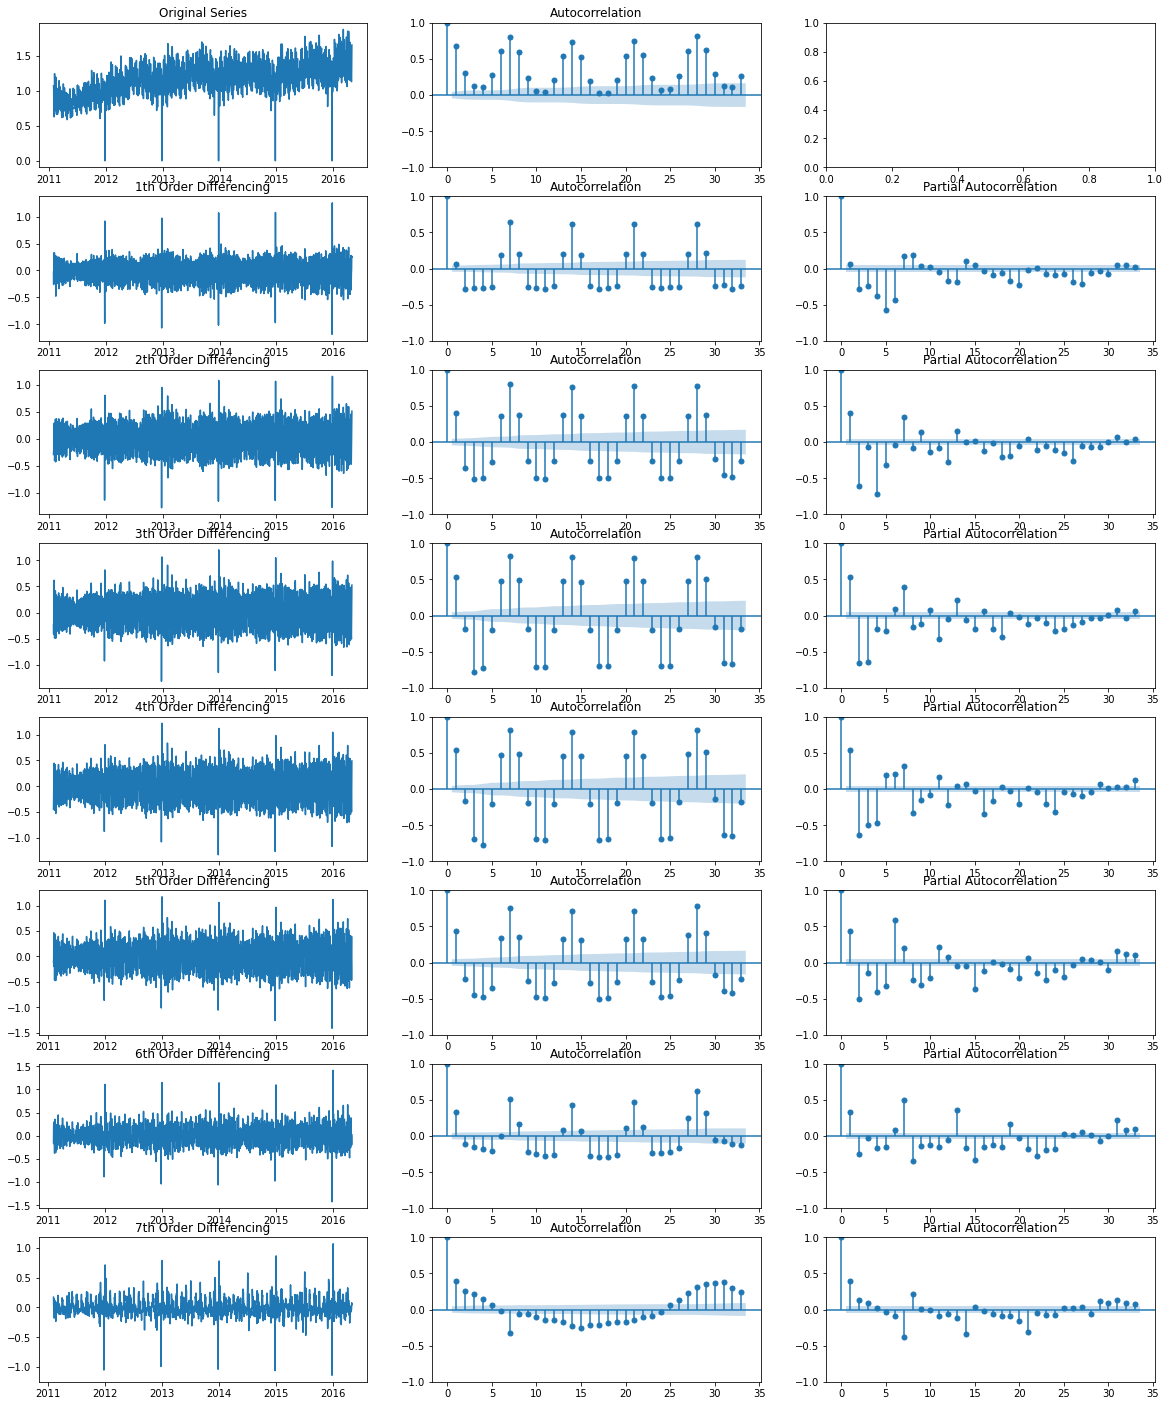

In [73]:
plot_differencing(df_items_temp["avg_items_sold"])

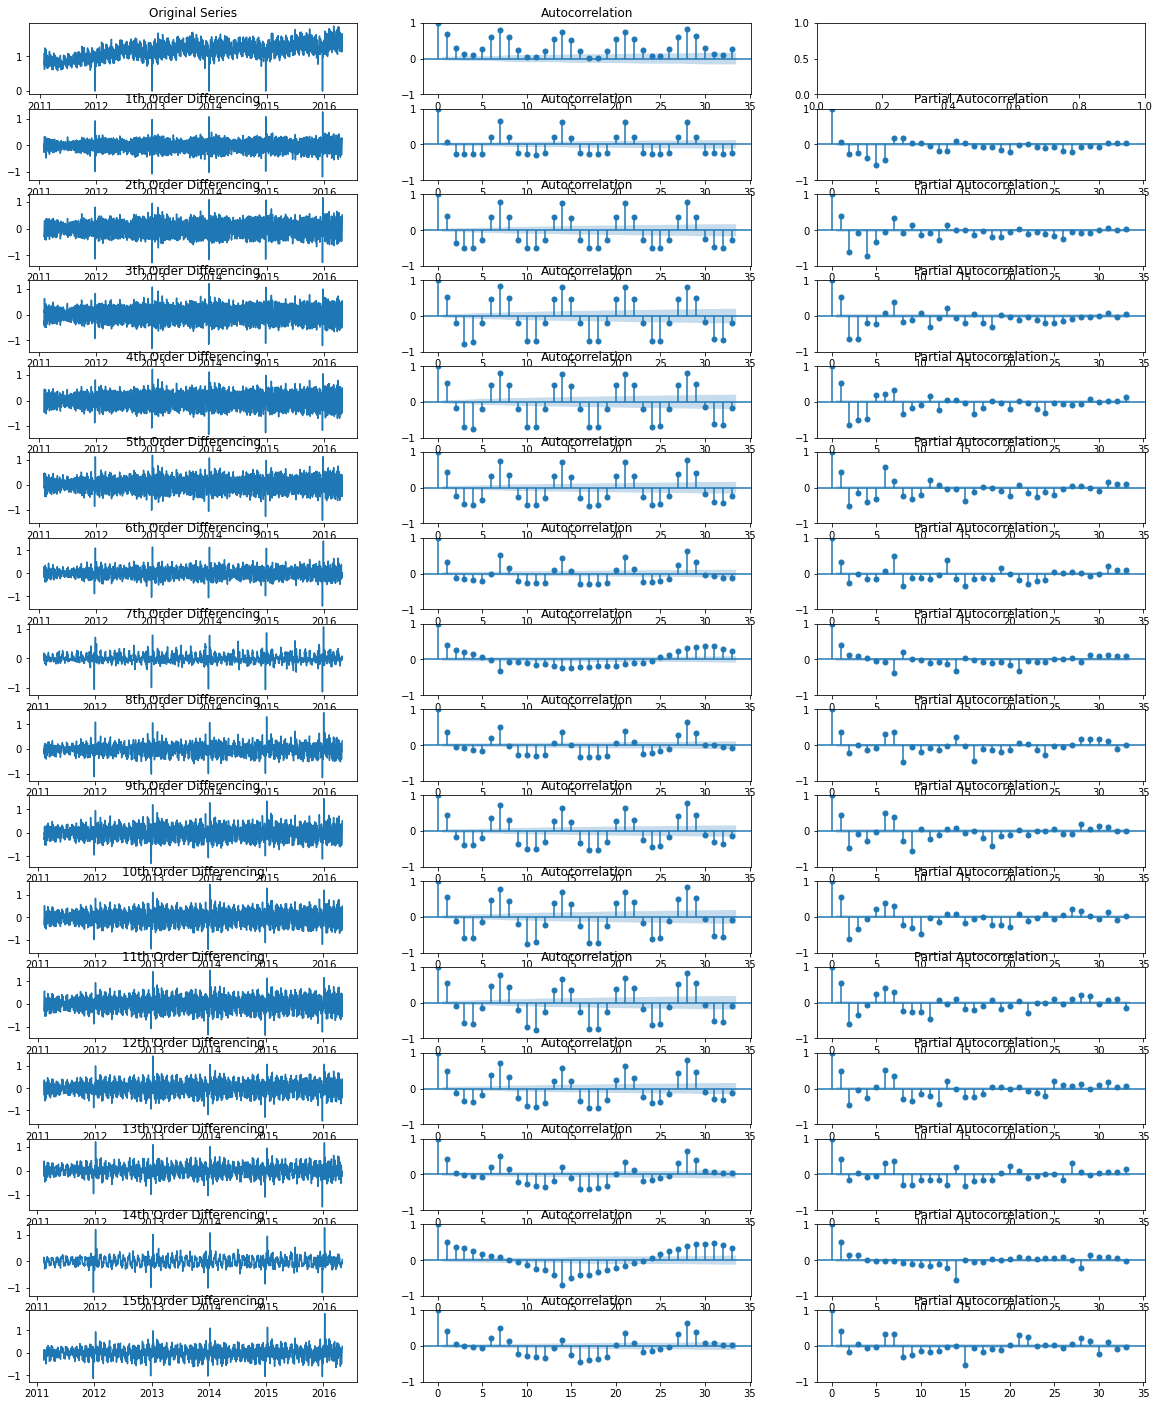

In [74]:
plot_differencing(df_items_temp["avg_items_sold"], n = 16)

#### Test for stationarity after differencing by 7

In [75]:
adf_test(df_items_temp["avg_items_sold"].diff(periods = 7).dropna())

Results of Dickey-Fuller Test:
Test Statistic                  -20.958364
p-value                           0.000000
#Lags Used                       23.000000
Number of Observations Used    1888.000000
Critical Value (1%)              -3.433818
Critical Value (5%)              -2.863072
Critical Value (10%)             -2.567586
dtype: float64


In [76]:
kpss_test(df_items_temp["avg_items_sold"].diff(periods = 7).dropna())

Results of KPSS Test:
Test Statistic            0.008453
p-value                   0.100000
Lags Used                19.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [77]:
df_items_temp["avg_items_sold"].diff(periods = 7).dropna()

date
2011-02-05    0.173860
2011-02-06    0.032371
2011-02-07    0.058675
2011-02-08   -0.076779
2011-02-09    0.147983
                ...   
2016-04-26   -0.068317
2016-04-27   -0.029452
2016-04-28   -0.009872
2016-04-29    0.078026
2016-04-30    0.048114
Name: avg_items_sold, Length: 1912, dtype: float64

#### Things to do (Vasu)

1. Better understanding SARIMA and how to derive the parameters from the ACF and PACF plots
2. Trying different test sizes, lmk what you think is a reasonable test size considering that the final forecast is 21 days 
3. Producing forecast in the form of sample_submission.csv, i.e. items sold per item per day

### Testing ARIMA model on average items sold

Fitting on the entire dataset, and then producing the forecast for a subset of the data.

Copying the code from [here](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/)
 and [here](https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/)

In [78]:
x = df_items_temp["avg_items_sold"]

model = ARIMA(x, order = (3, 1, 1), seasonal_order=(1,1,1,7))
fitted = model.fit()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


TODO: How to interpret results summary below? 

If P>|z| = 0.000, does that imply that results are very significant, or that there was some error? 

In [79]:
print(fitted.summary())

                                    SARIMAX Results                                    
Dep. Variable:                  avg_items_sold   No. Observations:                 1919
Model:             ARIMA(3, 1, 1)x(1, 1, 1, 7)   Log Likelihood                1608.312
Date:                         Tue, 25 Apr 2023   AIC                          -3202.623
Time:                                 17:48:57   BIC                          -3163.736
Sample:                             01-29-2011   HQIC                         -3188.312
                                  - 04-30-2016                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3277      0.013     25.092      0.000       0.302       0.353
ar.L2          0.0881      0.020      4.346      0.000     

#### Residuals plot

Does the plot show that most of the variance was captured? Other than the outliers at the end of each year

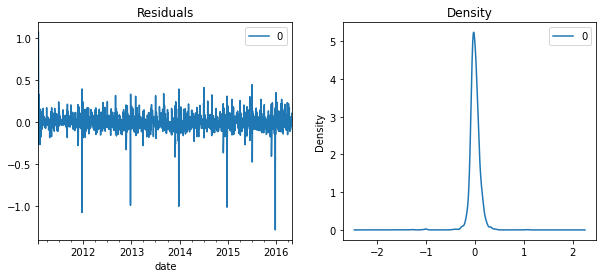

In [80]:
residuals = pd.DataFrame(fitted.resid)
fig, ax = plt.subplots(1,2, figsize = (10, 4))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

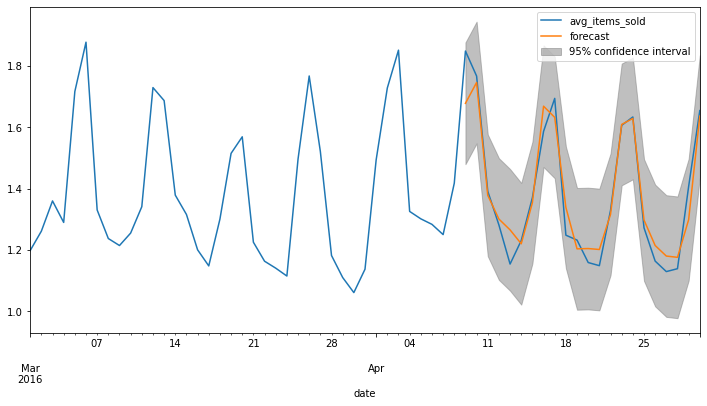

In [81]:
# Actual vs Fitted
fig, ax = plt.subplots(figsize = (12, 6))

# Compare predictions for the last 21 days of the training set
ax = df_items_temp["avg_items_sold"].loc["2016-03-01" : "2016-04-30"].plot(ax=ax)

# Predict until last day
plot_predict(fitted, "2016-04-09", "2016-04-30", ax = ax)
plt.show()

In [82]:
preds = fitted.get_prediction("2016-04-10", "2016-04-30")
rmse = sqrt(mean_squared_error(df_items_temp.loc["2016-04-10":"2016-04-30"]["avg_items_sold"], preds.predicted_mean))
print(rmse)

0.05236356033842277


### Forecasting with ARIMA

Using 80% of the data to train, then testing on a forecast of the next 90 days (because Kaggle submission is only for the next 21 days)

TODO: Consider other window forecasts? Is this a realistic estimate of performance, because the test size is so small?

TODO: Try other combinations of AR and MA, including the seasonal order component.

In [83]:
# Set number of days to forecast into the future
n = 21

# Split into test and train, training up till the last n - 1th day and predict the last n days
x_train, x_test = x[0:len(x)-n], x[len(x) - n:]

# Build Model
model = ARIMA(x_train, order = (3, 1, 1), seasonal_order=(1,1,2,7))
fitted = model.fit()

# Forecast n days ahead
fc = fitted.forecast(n) 

# Make as pandas series
fc_series = pd.Series(fc, index=df_items_temp["avg_items_sold"][len(x) - n:].index)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [84]:
print(fitted.summary())

                                      SARIMAX Results                                       
Dep. Variable:                       avg_items_sold   No. Observations:                 1898
Model:             ARIMA(3, 1, 1)x(1, 1, [1, 2], 7)   Log Likelihood                1576.482
Date:                              Tue, 25 Apr 2023   AIC                          -3136.965
Time:                                      17:49:03   BIC                          -3092.610
Sample:                                  01-29-2011   HQIC                         -3120.632
                                       - 04-09-2016                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3534      0.014     25.355      0.000       0.326       0.381
ar.L2          0.09

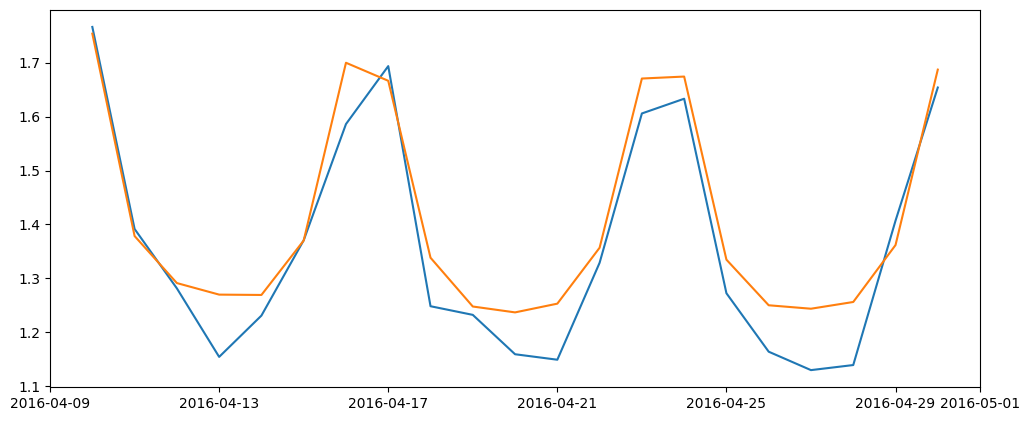

In [85]:
plt.figure(figsize=(12,5), dpi=100)
# plt.plot(x_train, label='training')
plt.plot(x_test, label='actual')
plt.plot(fc_series, label='forecast')
plt.show()

In [86]:
rmse = sqrt(mean_squared_error(x_test, fc_series))
print(rmse)

0.06965073262752242


### Forecast test 1 

Super simple method, training data is aggregated average across all items and all days in the train dataset.

Forecast all 21 days at once and assign predictions to all the items for all days.

In [87]:
df_sample_sub = pd.read_csv(SAMPLE_CSV_PATH)

In [88]:
# Build Model -  just average items sold first
model = ARIMA(df_items_temp["avg_items_sold"], order = (3, 1, 1), seasonal_order=(1,1,1,7))
fitted = model.fit()

print(fitted.summary())

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                    SARIMAX Results                                    
Dep. Variable:                  avg_items_sold   No. Observations:                 1919
Model:             ARIMA(3, 1, 1)x(1, 1, 1, 7)   Log Likelihood                1608.312
Date:                         Tue, 25 Apr 2023   AIC                          -3202.623
Time:                                 17:49:10   BIC                          -3163.736
Sample:                             01-29-2011   HQIC                         -3188.312
                                  - 04-30-2016                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3277      0.013     25.092      0.000       0.302       0.353
ar.L2          0.0881      0.020      4.346      0.000     

In [89]:
# Forecast n days ahead
fc = fitted.forecast(21) 
pred_time_period = pd.date_range(start = "2016-05-01", periods = 21)

# Make as pandas series
fc_series = pd.Series(fc).round().astype(int)

# Assign to all items
df_sample_sub.iloc[:,1:] = fc_series.values

In [90]:
# Export
# df_sample_sub.to_csv(EXPORT_PATH+"/submission_1.csv", header=True, index=False)

### Using AUTOARIMA (on product subcategory level)

#### Structuring data for forecasting

In [91]:
df_train.head()
unique_subcats = list(df_train.subcat_id.unique())
unique_subcats


['Beauty_1',
 'Beauty_2',
 'Cleaning_1',
 'Cleaning_2',
 'Food_1',
 'Food_2',
 'Food_3']

In [92]:
# Group the data by subcat
df_subcat_grp = df_train.groupby(['subcat_id'], as_index=False).mean()

# Create datetime df matching to the day index
df_dates = pd.DataFrame(columns = ["d"], data = df_train.columns[6:])
df_dates = df_dates.merge(df_cal[["date", "d"]], on = "d", how = "left")

# Split into separate series, 1 for each subcategory
s_beauty_1 = pd.Series(list(df_subcat_grp.iloc[0,1:]), index = df_dates["date"])
s_beauty_2 = pd.Series(list(df_subcat_grp.iloc[1,1:]), index = df_dates["date"])
s_cleaning_1 = pd.Series(list(df_subcat_grp.iloc[2,1:]), index = df_dates["date"])
s_cleaning_2 = pd.Series(list(df_subcat_grp.iloc[3,1:]), index = df_dates["date"])
s_food_1 = pd.Series(list(df_subcat_grp.iloc[4,1:]), index = df_dates["date"])
s_food_2 = pd.Series(list(df_subcat_grp.iloc[5,1:]), index = df_dates["date"])
s_food_3 = pd.Series(list(df_subcat_grp.iloc[6,1:]), index = df_dates["date"])


# Train test split
train, test = train_test_split(s_beauty_1, train_size=0.8)

In [93]:
# Save item indices for assigning predictions to the three product subcategories after forecasting
beauty_1_idx = df_train[df_train["subcat_id"] == "Beauty_1"].index
beauty_2_idx = df_train[df_train["subcat_id"] == "Beauty_2"].index
cleaning_1_idx = df_train[df_train["subcat_id"] == "Cleaning_1"].index
cleaning_2_idx = df_train[df_train["subcat_id"] == "Cleaning_2"].index
food_1_idx = df_train[df_train["subcat_id"] == "Food_1"].index
food_2_idx = df_train[df_train["subcat_id"] == "Food_2"].index
food_3_idx = df_train[df_train["subcat_id"] == "Food_3"].index

In [94]:
# Fit a simple auto_arima model (not SARIMA)
modl = auto_arima(train, start_p=1, start_q=1, start_P=1, start_Q=1,
                     max_p=10, max_q=10, max_P=10, max_Q=10, 
                     seasonal=True, stepwise=False, random = True, n_jobs = -1, 
                     suppress_warnings=True, max_d=10, max_D=10,
                     trace = True, error_action='ignore')

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=-1925.388, Time=0.31 sec
 ARIMA(3,1,0)(0,0,0)[1] intercept   : AIC=-2102.879, Time=0.70 sec
 ARIMA(4,1,0)(0,0,0)[1] intercept   : AIC=-2258.157, Time=1.14 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=-2530.931, Time=2.21 sec
 ARIMA(3,1,1)(0,0,0)[1] intercept   : AIC=-2593.057, Time=3.21 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=-2478.752, Time=2.54 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=-2445.579, Time=3.09 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=-2541.851, Time=3.74 sec
 ARIMA(4,1,1)(0,0,0)[1] intercept   : AIC=-2685.922, Time=3.76 sec
 ARIMA(3,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=4.18 sec

Best model:  ARIMA(4,1,1)(0,0,0)[1] intercept
Total fit time: 10.895 seconds


In [95]:
print(modl.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1535
Model:               SARIMAX(4, 1, 1)   Log Likelihood                1349.961
Date:                Tue, 25 Apr 2023   AIC                          -2685.922
Time:                        17:49:23   BIC                          -2648.573
Sample:                    01-29-2011   HQIC                         -2672.024
                         - 04-12-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0001      0.000      0.321      0.748      -0.001       0.001
ar.L1          0.3169      0.022     14.713      0.000       0.275       0.359
ar.L2         -0.2921      0.026    -11.362      0.0

In [96]:
# Fit a seasonal auto_arima model (m = 7, weekly seasonality)
modl_seasonal = auto_arima(train, start_p=1, start_q=1, start_P=1, start_Q=1,
                     max_p=10, max_q=10, max_P=10, max_Q=10, max_d = 10, max_D=10, m = 7, 
                     seasonal=True, stepwise=False, random = True, n_jobs = -1, 
                     random_state = 0, suppress_warnings=True,
                     error_action='ignore', trace = True)

 ARIMA(2,1,0)(0,0,0)[7] intercept   : AIC=-2025.219, Time=0.51 sec
 ARIMA(0,1,4)(1,0,0)[7] intercept   : AIC=-2910.112, Time=4.15 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=5.07 sec
 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=inf, Time=5.77 sec
 ARIMA(0,1,2)(2,0,0)[7] intercept   : AIC=-3078.317, Time=6.78 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=inf, Time=7.31 sec
 ARIMA(0,1,3)(1,0,1)[7] intercept   : AIC=-3330.007, Time=7.89 sec
 ARIMA(3,1,0)(0,0,1)[7] intercept   : AIC=-2370.924, Time=3.69 sec
 ARIMA(2,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=8.51 sec
 ARIMA(0,1,1)(0,0,3)[7] intercept   : AIC=-2727.189, Time=9.78 sec

Best model:  ARIMA(0,1,3)(1,0,1)[7] intercept
Total fit time: 10.699 seconds


In [97]:
print(modl_seasonal.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                 1535
Model:             SARIMAX(0, 1, 3)x(1, 0, [1], 7)   Log Likelihood                1672.003
Date:                             Tue, 25 Apr 2023   AIC                          -3330.007
Time:                                     17:49:34   BIC                          -3292.658
Sample:                                 01-29-2011   HQIC                         -3316.109
                                      - 04-12-2015                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4.911e-07   8.32e-06      0.059      0.953   -1.58e-05    1.68e-05
ma.L1         -0.6896      

#### Predictions on 20% of data

In [98]:
# Create predictions for the future, evaluate on test
preds, conf_int = modl.predict(n_periods=test.shape[0], return_conf_int=True)

# Print the error:
print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(test, preds)))

Test RMSE: 0.129


In [99]:
# Create predictions for the future, evaluate on test
preds_seasonal, conf_int_seasonal = modl_seasonal.predict(n_periods=test.shape[0], return_conf_int=True)

# Print the error:
print("Test RMSE: %.3f" % np.sqrt(mean_squared_error(test, preds_seasonal)))

Test RMSE: 0.133


Text(0.5, 1.0, 'Items sold for Beauty (ARIMA)')

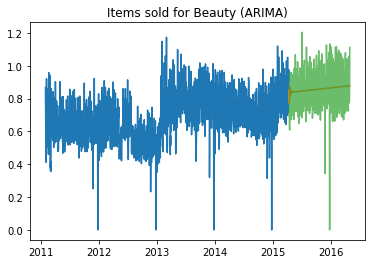

In [100]:
# Plot the points and the forecasts
plt.plot(train)
plt.plot(preds)
plt.plot(test, alpha = 0.7)
plt.title("Items sold for Beauty (ARIMA)")

Text(0.5, 1.0, 'Items sold for Beauty (SARIMA)')

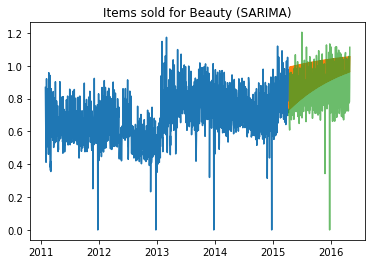

In [101]:
# Plot the points and the forecasts
plt.plot(train)
plt.plot(preds_seasonal)
plt.plot(test, alpha = 0.7)
plt.title("Items sold for Beauty (SARIMA)")

Text(0.5, 1.0, 'Forecasts (ARIMA) and preditions (testing on 20% of training data)')

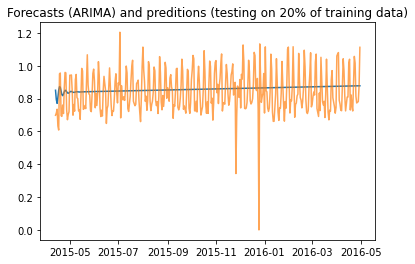

In [102]:
plt.plot(preds)
plt.plot(test, alpha = 0.7)
plt.title("Forecasts (ARIMA) and preditions (testing on 20% of training data)")

Text(0.5, 1.0, 'Forecasts (SARIMA) and preditions (testing on 20% of training data)')

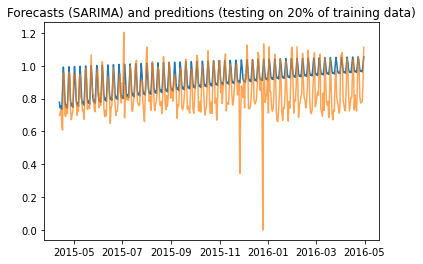

In [103]:
plt.plot(preds_seasonal)
plt.plot(test, alpha = 0.7)
plt.title("Forecasts (SARIMA) and preditions (testing on 20% of training data)")

#### Predictions for the next 21 days (according to submission format)

Kaggle score: 3.89

In [104]:
# Fit a seasonal auto_arima model (m = 7, weekly seasonality)
modl_seasonal_beauty_1 = auto_arima(s_beauty_1, start_p=1, start_q=1, start_P=1, start_Q=1,
                     max_p=10, max_q=10, max_P=10, max_Q=10, max_d = 10, max_D=10, m = 7, 
                     seasonal=True, stepwise=False, random = True, n_jobs = -1, 
                     random_state = 0, suppress_warnings=True,
                     error_action='ignore', trace = True)

 ARIMA(2,1,0)(0,0,0)[7] intercept   : AIC=-2404.232, Time=0.78 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=3.99 sec
 ARIMA(0,1,4)(1,0,0)[7] intercept   : AIC=-3554.734, Time=6.32 sec
 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=inf, Time=7.18 sec
 ARIMA(0,1,3)(1,0,1)[7] intercept   : AIC=-4115.594, Time=7.82 sec
 ARIMA(3,1,0)(0,0,1)[7] intercept   : AIC=-2852.432, Time=3.16 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=inf, Time=8.25 sec
 ARIMA(0,1,2)(2,0,0)[7] intercept   : AIC=-3786.486, Time=8.72 sec
 ARIMA(2,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=9.39 sec
 ARIMA(0,1,1)(0,0,3)[7] intercept   : AIC=-3359.613, Time=12.12 sec

Best model:  ARIMA(0,1,3)(1,0,1)[7] intercept
Total fit time: 13.272 seconds


In [105]:
pred_beauty_1 = modl_seasonal_beauty_1.predict(21).apply(np.ceil)

In [106]:
# Fit a seasonal auto_arima model (m = 7, weekly seasonality)
modl_seasonal_beauty_2 = auto_arima(s_beauty_2, start_p=1, start_q=1, start_P=1, start_Q=1,
                     max_p=10, max_q=10, max_P=10, max_Q=10, max_d = 10, max_D=10, m = 7, 
                     seasonal=True, stepwise=False, random = True, n_jobs = -1, 
                     random_state = 0, suppress_warnings=True,
                     error_action='ignore', trace = True)

 ARIMA(2,1,0)(0,0,0)[7] intercept   : AIC=-7111.665, Time=0.73 sec
 ARIMA(0,1,4)(1,0,0)[7] intercept   : AIC=-7319.533, Time=3.69 sec
 ARIMA(0,1,2)(2,0,0)[7] intercept   : AIC=-7337.153, Time=4.39 sec
 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=inf, Time=6.03 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=5.30 sec
 ARIMA(3,1,0)(0,0,1)[7] intercept   : AIC=-7228.238, Time=2.43 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=inf, Time=6.34 sec
 ARIMA(0,1,3)(1,0,1)[7] intercept   : AIC=-7468.534, Time=6.48 sec
 ARIMA(0,1,1)(0,0,3)[7] intercept   : AIC=-7300.541, Time=8.79 sec
 ARIMA(2,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=9.22 sec

Best model:  ARIMA(0,1,3)(1,0,1)[7] intercept
Total fit time: 10.252 seconds


In [107]:
pred_beauty_2 = modl_seasonal_beauty_2.predict(21).apply(np.ceil)

In [108]:
# Fit a seasonal auto_arima model (m = 7, weekly seasonality)
modl_seasonal_cleaning_1 = auto_arima(s_cleaning_1, start_p=1, start_q=1, start_P=1, start_Q=1,
                     max_p=10, max_q=10, max_P=10, max_Q=10, max_d = 10, max_D=10, m = 7, 
                     seasonal=True, stepwise=False, random = True, n_jobs = -1, 
                     random_state = 0, suppress_warnings=True,
                     error_action='ignore', trace = True)

 ARIMA(2,1,0)(0,0,0)[7] intercept   : AIC=-426.139, Time=0.35 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=2.89 sec
 ARIMA(0,1,4)(1,0,0)[7] intercept   : AIC=-2039.975, Time=4.67 sec
 ARIMA(3,1,0)(0,0,1)[7] intercept   : AIC=-1030.301, Time=1.95 sec
 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=inf, Time=5.91 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=inf, Time=6.59 sec
 ARIMA(0,1,3)(1,0,1)[7] intercept   : AIC=-2608.803, Time=6.64 sec
 ARIMA(0,1,2)(2,0,0)[7] intercept   : AIC=inf, Time=8.01 sec
 ARIMA(2,1,0)(2,0,1)[7] intercept   : AIC=-2458.243, Time=8.10 sec
 ARIMA(0,1,1)(0,0,3)[7] intercept   : AIC=-1494.277, Time=9.20 sec

Best model:  ARIMA(0,1,3)(1,0,1)[7] intercept
Total fit time: 10.296 seconds


In [109]:
pred_cleaning_1 = modl_seasonal_cleaning_1.predict(21).apply(np.ceil)

In [110]:
# Fit a seasonal auto_arima model (m = 7, weekly seasonality)
modl_seasonal_cleaning_2 = auto_arima(s_cleaning_2, start_p=1, start_q=1, start_P=1, start_Q=1,
                     max_p=10, max_q=10, max_P=10, max_Q=10, max_d = 10, max_D=10, m = 7, 
                     seasonal=True, stepwise=False, random = True, n_jobs = -1, 
                     random_state = 0, suppress_warnings=True,
                     error_action='ignore', trace = True)

 ARIMA(2,1,0)(0,0,0)[7] intercept   : AIC=-5526.448, Time=0.34 sec
 ARIMA(0,1,3)(1,0,1)[7] intercept   : AIC=-7719.967, Time=3.42 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=3.61 sec
 ARIMA(0,1,4)(1,0,0)[7] intercept   : AIC=-7381.700, Time=4.04 sec
 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=-7216.699, Time=5.50 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=-7580.946, Time=6.45 sec
 ARIMA(3,1,0)(0,0,1)[7] intercept   : AIC=-6142.961, Time=2.78 sec
 ARIMA(0,1,2)(2,0,0)[7] intercept   : AIC=inf, Time=7.01 sec
 ARIMA(2,1,0)(2,0,1)[7] intercept   : AIC=-7724.295, Time=7.33 sec
 ARIMA(0,1,1)(0,0,3)[7] intercept   : AIC=-7016.635, Time=8.86 sec

Best model:  ARIMA(2,1,0)(2,0,1)[7] intercept
Total fit time: 9.958 seconds


In [111]:
pred_cleaning_2 = modl_seasonal_cleaning_2.predict(21).apply(np.ceil)

In [112]:
# Fit a seasonal auto_arima model (m = 7, weekly seasonality)
modl_seasonal_food_1 = auto_arima(s_food_1, start_p=1, start_q=1, start_P=1, start_Q=1,
                     max_p=10, max_q=10, max_P=10, max_Q=10, max_d = 10, max_D=10, m = 7, 
                     seasonal=True, stepwise=False, random = True, n_jobs = -1, 
                     random_state = 0, suppress_warnings=True,
                     error_action='ignore', trace = True)

 ARIMA(2,1,0)(0,0,0)[7] intercept   : AIC=-514.711, Time=0.25 sec
 ARIMA(0,1,2)(2,0,0)[7] intercept   : AIC=-1293.718, Time=4.05 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=3.81 sec
 ARIMA(0,1,4)(1,0,0)[7] intercept   : AIC=-1312.954, Time=4.16 sec
 ARIMA(0,1,1)(0,0,3)[7] intercept   : AIC=-991.005, Time=4.94 sec
 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=inf, Time=5.22 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=inf, Time=5.78 sec
 ARIMA(3,1,0)(0,0,1)[7] intercept   : AIC=-847.640, Time=1.59 sec
 ARIMA(0,1,3)(1,0,1)[7] intercept   : AIC=-1632.001, Time=6.60 sec
 ARIMA(2,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=6.93 sec

Best model:  ARIMA(0,1,3)(1,0,1)[7] intercept
Total fit time: 7.743 seconds


In [113]:
pred_food_1 = modl_seasonal_food_1.predict(21).apply(np.ceil)

In [114]:
# Fit a seasonal auto_arima model (m = 7, weekly seasonality)
modl_seasonal_food_2 = auto_arima(s_food_2, start_p=1, start_q=1, start_P=1, start_Q=1,
                     max_p=10, max_q=10, max_P=10, max_Q=10, max_d = 10, max_D=10, m = 7, 
                     seasonal=True, stepwise=False, random = True, n_jobs = -1, 
                     random_state = 0, suppress_warnings=True,
                     error_action='ignore', trace = True)

 ARIMA(2,1,0)(0,0,0)[7] intercept   : AIC=-1163.027, Time=0.25 sec
 ARIMA(0,1,4)(1,0,0)[7] intercept   : AIC=-1696.467, Time=2.90 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=3.39 sec
 ARIMA(0,1,1)(0,0,3)[7] intercept   : AIC=-1588.484, Time=4.82 sec
 ARIMA(3,1,0)(0,0,1)[7] intercept   : AIC=-1462.353, Time=1.82 sec
 ARIMA(0,1,3)(1,0,1)[7] intercept   : AIC=-2228.522, Time=5.31 sec
 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=inf, Time=5.51 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=inf, Time=6.63 sec
 ARIMA(2,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=7.08 sec
 ARIMA(0,1,2)(2,0,0)[7] intercept   : AIC=-1819.142, Time=7.34 sec

Best model:  ARIMA(0,1,3)(1,0,1)[7] intercept
Total fit time: 8.525 seconds


In [115]:
pred_food_2 = modl_seasonal_food_2.predict(21).apply(np.ceil)

In [116]:
# Fit a seasonal auto_arima model (m = 7, weekly seasonality)
modl_seasonal_food_3 = auto_arima(s_food_3, start_p=1, start_q=1, start_P=1, start_Q=1,
                     max_p=10, max_q=10, max_P=10, max_Q=10, max_d = 10, max_D=10, m = 7, 
                     seasonal=True, stepwise=False, random = True, n_jobs = -1, 
                     random_state = 0, suppress_warnings=True,
                     error_action='ignore', trace = True)

 ARIMA(2,1,0)(0,0,0)[7] intercept   : AIC=1487.600, Time=0.28 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=3.22 sec
 ARIMA(0,1,4)(1,0,0)[7] intercept   : AIC=110.688, Time=4.04 sec
 ARIMA(0,1,1)(0,0,3)[7] intercept   : AIC=588.435, Time=4.08 sec
 ARIMA(3,1,0)(0,0,1)[7] intercept   : AIC=871.962, Time=1.36 sec
 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=inf, Time=5.11 sec
 ARIMA(0,1,3)(1,0,1)[7] intercept   : AIC=-353.645, Time=5.44 sec
 ARIMA(0,1,2)(2,0,0)[7] intercept   : AIC=inf, Time=6.02 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=inf, Time=6.61 sec
 ARIMA(2,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=6.80 sec

Best model:  ARIMA(0,1,3)(1,0,1)[7] intercept
Total fit time: 7.498 seconds


In [117]:
pred_food_3 = modl_seasonal_food_3.predict(21).apply(np.ceil)

In [118]:
# Fit a seasonal auto_arima model (m = 7, weekly seasonality)
# modl_seasonal_food = auto_arima(s_food, start_p=1, start_q=1, start_P=1, start_Q=1,
#                      max_p=10, max_q=10, max_P=10, max_Q=10, max_d = 10, max_D=10, m = 7, 
#                      seasonal=True, stepwise=False, random = True, n_jobs = -1, 
#                      random_state = 0, suppress_warnings=True,
#                      error_action='ignore', trace = True)

In [119]:
# pred_food = modl_seasonal_food.predict(21).apply(np.ceil)

In [120]:
# # Fit a seasonal auto_arima model (m = 7, weekly seasonality)
# modl_seasonal_cleaning = auto_arima(s_cleaning, start_p=1, start_q=1, start_P=1, start_Q=1,
#                      max_p=10, max_q=10, max_P=10, max_Q=10, max_d = 10, max_D=10, m = 7, 
#                      seasonal=True, stepwise=False, random = True, n_jobs = -1, 
#                      random_state = 0, suppress_warnings=True,
#                      error_action='ignore', trace = True)

In [121]:
# pred_cleaning = modl_seasonal_cleaning.predict(21).apply(np.ceil)

## Exporting 

In [122]:
df_sample_sub = pd.read_csv(SAMPLE_CSV_PATH)
df_sample_sub.head()

,id,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,...,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940
0,Beauty_1_001_East_1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,Beauty_1_002_East_1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,Beauty_1_003_East_1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,Beauty_1_004_East_1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,Beauty_1_005_East_1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [123]:
# Assign predictions to 
df_sample_sub.iloc[beauty_1_idx, 1:] = pred_beauty_1.values
df_sample_sub.iloc[beauty_2_idx, 1:] = pred_beauty_2.values
df_sample_sub.iloc[cleaning_1_idx, 1:] = pred_cleaning_1.values
df_sample_sub.iloc[cleaning_2_idx, 1:] = pred_cleaning_2.values
df_sample_sub.iloc[food_1_idx, 1:] = pred_food_1.values
df_sample_sub.iloc[food_2_idx, 1:] = pred_food_2.values
df_sample_sub.iloc[food_3_idx, 1:] = pred_food_3.values

In [124]:
df_sample_sub

,id,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,...,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940
0,Beauty_1_001_East_1,1,1,1,1,1,1,2,1,1,...,1,1,2,1,1,1,1,1,1,2
1,Beauty_1_002_East_1,1,1,1,1,1,1,2,1,1,...,1,1,2,1,1,1,1,1,1,2
2,Beauty_1_003_East_1,1,1,1,1,1,1,2,1,1,...,1,1,2,1,1,1,1,1,1,2
3,Beauty_1_004_East_1,1,1,1,1,1,1,2,1,1,...,1,1,2,1,1,1,1,1,1,2
4,Beauty_1_005_East_1,1,1,1,1,1,1,2,1,1,...,1,1,2,1,1,1,1,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,Food_3_823_West_3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
30486,Food_3_824_West_3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
30487,Food_3_825_West_3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
30488,Food_3_826_West_3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3


In [62]:
# Export
df_sample_sub.to_csv(EXPORT_PATH+"/submission_3.csv", header=True, index=False)

#### Rolling forecast ARIMA model

Copying code from [here](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/)

In [23]:
# history = [x for x in x_train]
# predictions = list()

# for t in range(len(x_test)):
    
#     # Order taken from eda (hypothesis after looking at plots) 
#     print(t)
#     model = ARIMA(history, order=(11,7,8))
#     model_fit = model.fit()
#     output = model_fit.forecast()
#     yhat = output[0]
#     predictions.append(yhat)
#     obs = x_test[t]
#     history.append(obs)
#     # print('predicted=%f, expected=%f' % (yhat, obs))

0


c:\Users\Tristan\Desktop\Assignments\ADS\ads-final-project\ads_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Tristan\Desktop\Assignments\ADS\ads-final-project\ads_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


1


c:\Users\Tristan\Desktop\Assignments\ADS\ads-final-project\ads_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


2


c:\Users\Tristan\Desktop\Assignments\ADS\ads-final-project\ads_env\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


3


In [ ]:
# rmse = sqrt(mean_squared_error(x_test, predictions))
# print('Test RMSE: %.3f' % rmse)

In [ ]:
# plt.plot(x_test)
# plt.plot(predictions, color='red')
# plt.show()